## Financial Analysis of Hydrogen Financing Using PyPSA-Earth

This notebook utilizes the PyPSA-Earth framework to analyze the financial aspects of hydrogen within a given network (.nc) file. The analysis includes detailed calculations and visualizations of:

- Hydrogen Capital Expenditures (CAPEX)
- Hydrogen Operational Expenditures (OPEX)
- Hydrogen Supply
- Hydrogen Revenue
- Levelized Cost of Hydrogen (LCOH)

By examining these financial metrics, insights into the economic feasibility and cost structure of hydrogen production in the modeled network are provided.

Sources: 
- Statistics module: https://pypsa.readthedocs.io/en/latest/examples/statistics.html
- Templates and colors: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/network_analysis.ipynb

File is needed:
* PyPSA network file (.nc) includes the hydrogen financing information.
* Configuration file (.yaml) with H2 Electrolysis color

### Import packages

In [56]:
import yaml
import pypsa
import matplotlib.pyplot as plt
import os
import sys

### Path settings
This section reads the config parameters from your config.yaml file and automatically reads the output of the optimization with those settings

In [57]:
# change current directory to parent folder
if not os.path.isdir("pypsa-earth"):
    os.chdir("../..")
sys.path.append(os.getcwd()+"/pypsa-earth/scripts")

PARENT = os.path.realpath("pypsa-earth/") + "/"
config = yaml.safe_load(open(PARENT + "config.yaml"))

In [58]:
run_name = config["run"]["name"]                          
simpl = config["scenario"]["simpl"]                    
load_scale = config["load_options"]["scale"]               
opts = config["scenario"]["opts"]                     
planning = config["scenario"]["planning_horizons"]        
discountrate = config["costs"]["discountrate"]                
demand = config["scenario"]["demand"]                  
export_value = config["export"]["h2export"]                  

# Process each setting into a string representation 
simpl_str = "_".join(map(str, simpl))                    
scale_str = f"lc{load_scale}"                           
opts_str = "_".join(map(str, opts))                     
planning_str = "_".join(map(str, planning))               
dr_str = "_".join(map(str, discountrate))             
demand_str = "_".join(map(str, demand))                    
export_str = "_".join(map(str, export_value)) + "export"   

nc_file_name = (
    f"elec_s_{simpl_str}_ec_{scale_str}_{opts_str}_"
    f"{planning_str}_{dr_str}_{demand_str}_{export_str}.nc"
)

### Analysis Network Setup

In [59]:
scenario_subpath = f"{run_name}/" if run_name else ""
results_path = PARENT + f"results/networks/{nc_file_name}"

n = pypsa.Network(results_path)
statistics = n.statistics()
hydrogen_color = config["plotting"]["tech_colors"]["high-temp electrolysis"]

Index(['H2 pipeline NZ.15_1 -> NZ.17_1', 'H2 pipeline NZ.17_1 -> NZ.1_1',
       'H2 pipeline NZ.1_1 -> NZ.11_1'],
      dtype='object', name='name')
Index(['H2 pipeline NZ.15_1 -> NZ.17_1', 'H2 pipeline NZ.17_1 -> NZ.1_1',
       'H2 pipeline NZ.1_1 -> NZ.11_1'],
      dtype='object', name='name')
INFO:pypsa.io:Imported network elec_s_10_ec_lc3.0_Co2L_3H_2035_0.071_AB_14export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


### Basic Ideas

In [60]:
def plot_metric_share(statistics, metric, total_metric, label, title, unit):
    """
    Plot the share of a specific metric (e.g., CAPEX, OPEX, Supply, Revenue) for hydrogen as a pie chart.
    
    Parameters:
        statistics (pd.DataFrame): DataFrame containing metric information.
        metric (str): Metric type (e.g., 'Capital Expenditure', 'Operational Expenditure', 'Supply', 'Revenue').
        total_metric (float): Total value of the metric for all components (e.g., in Mio. €, TWh).
        label (str): Label for hydrogen factor in the chart.
        title (str): Title for the pie chart.
        unit (str): Unit of the metric for display (e.g., 'Mio. €', 'TWh').
    """
    # Calculate hydrogen metric
    h2_metric = (statistics.loc["Link", "H2 Electrolysis"][metric] / 1e6).round(2)
    other_metric = (total_metric - h2_metric).round(2)

    # Print metric details
    print(f"H2 {label} is: {h2_metric} {unit}")
    print(f"Other {label} is: {other_metric} {unit}")
    print(f"Total {label} is: {total_metric} {unit}")

    # Prepare data for the pie chart
    values = [h2_metric, other_metric]
    labels = [f"H2 {label}", f"Other {label}"]
    colors = [hydrogen_color, "lightgrey"]

    # Plot the pie chart
    plt.figure(figsize=(6, 6))  # Set figure size
    plt.pie(values, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title(title)
    plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 0.8))
    plt.axis('equal')  # Ensures the pie chart is circular
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


In [61]:
h2_electrolysis = (
        statistics.loc["Link", "H2 Electrolysis"]
)
h2_electrolysis

Optimal Capacity           6.158121e+03
Installed Capacity         0.000000e+00
Supply                     1.643287e+07
Withdrawal                 2.347553e+07
Energy Balance            -7.042659e+06
Transmission               0.000000e+00
Capacity Factor            4.351741e-01
Curtailment                0.000000e+00
Capital Expenditure        2.104466e+08
Operational Expenditure    2.184250e+05
Revenue                    2.106629e+08
Market Value               1.281961e+01
Name: (Link, H2 Electrolysis), dtype: float64

H2 CAPEX is: 210.45 Mio. €
Other CAPEX is: 11.32 Mio. €
Total CAPEX is: 221.77 Mio. €


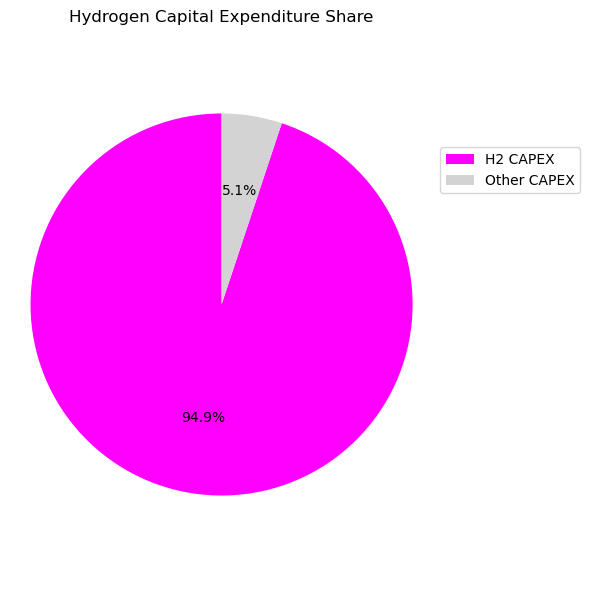

In [62]:
# CAPEX Example
total_capex = (n.statistics.capex(comps=["Link"]).sum() / 1e6).round(2)
plot_metric_share(
    statistics=statistics,
    metric="Capital Expenditure",
    total_metric=total_capex,
    label="CAPEX",
    title="Hydrogen Capital Expenditure Share",
    unit="Mio. €",
)

H2 OPEX is: 0.22 Mio. €
Other OPEX is: 4.92 Mio. €
Total OPEX is: 5.14 Mio. €


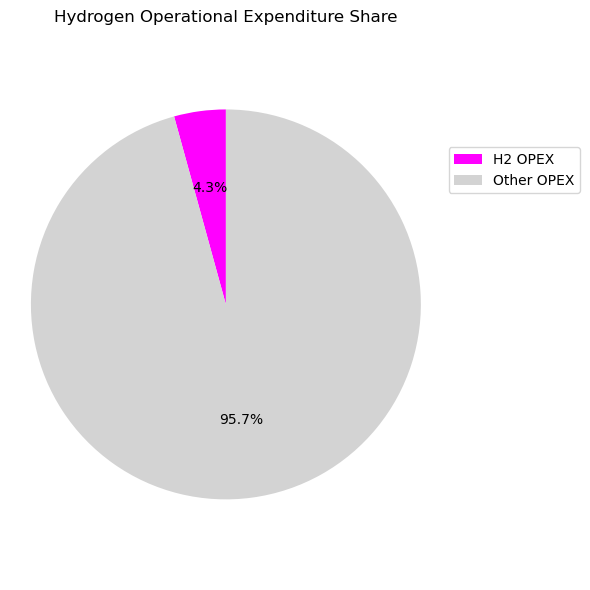

In [63]:
total_opex = (n.statistics.opex(comps=["Link"]).sum() / 1e6).round(2)
plot_metric_share(
    statistics=statistics,
    metric="Operational Expenditure",
    total_metric=total_opex,
    label="OPEX",
    title="Hydrogen Operational Expenditure Share",
    unit="Mio. €",
)


H2 Supply is: 16.43 TWh
Other Supply is: 70.86 TWh
Total Supply is: 87.29 TWh


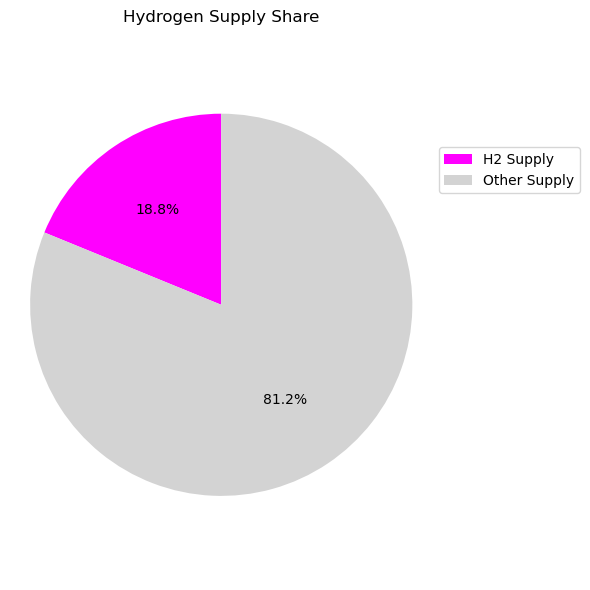

In [64]:
total_supply = (n.statistics.supply(comps=["Link"]).sum() / 1e6).round(2)
plot_metric_share(
    statistics=statistics,
    metric="Supply",
    total_metric=total_supply,
    label="Supply",
    title="Hydrogen Supply Share",
    unit="TWh",
)

H2 Revenue is: 210.66 Mio. €
Other Revenue is: 16.72 Mio. €
Total Revenue is: 227.38 Mio. €


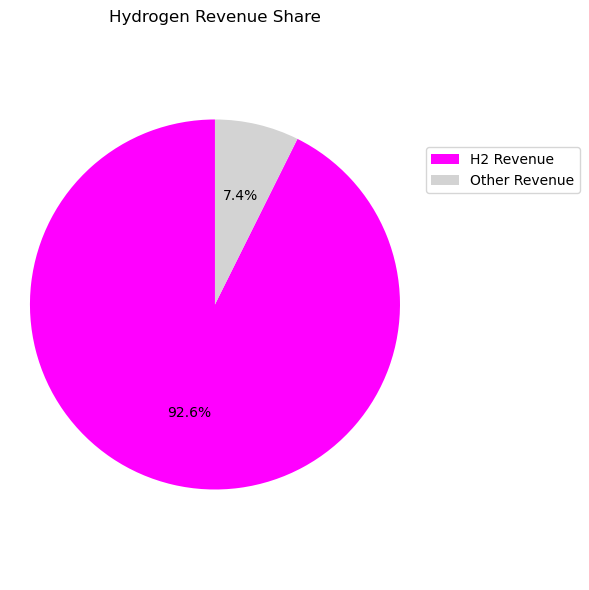

In [65]:
total_revenue = (n.statistics.revenue(comps=["Link"]).sum() / 1e6).round(2)
plot_metric_share(
    statistics=statistics,
    metric="Revenue",
    total_metric=total_revenue,
    label="Revenue",
    title="Hydrogen Revenue Share",
    unit="Mio. €",
)

In [66]:
h2_capex = (
        statistics.loc["Link", "H2 Electrolysis"]
        .loc["Capital Expenditure"]
        .round(2)
        / 1e6
) 

h2_opex = (
        statistics.loc["Link", "H2 Electrolysis"]
        .loc["Operational Expenditure"]
        .round(2)
        / 1e6
) 

h2_supply = (
        statistics.loc["Link", "H2 Electrolysis"]
        .loc["Supply"]
        .round(2)
        / 1e6
) 

# Determine expense on electricity for hydrogen production
buses_sel = n.buses[n.buses.carrier == "AC"].index
prices = n.buses_t.marginal_price[buses_sel]
demand = n.links_t.p1[n.links[n.links.carrier == "H2 Electrolysis"].index]

demand.columns = (
    prices.columns
)  # Adjust column names to match prices for multiplication

e_cost = (
    (prices * demand).sum().sum()
    * (-1)
    * n.snapshot_weightings.generators[0]
    / 1e6
)  # in Mio. €

lcoh_compo = ((h2_opex + h2_opex + e_cost) / h2_supply).round(2)  # in €/MWh
print(f"Levelized Cost of Hydrogen (LCOH) is: {lcoh_compo} €/MWh")

Levelized Cost of Hydrogen (LCOH) is: 28.01 €/MWh


/tmp/ipykernel_3574/3728563782.py:34: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

